In [ ]:
!pip install pandas matplotlib seaborn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [17]:
customers = pd.read_csv('/content/olist_customers_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
geo = pd.read_csv('/content/olist_geolocation_dataset.csv')
translations = pd.read_csv('/content/product_category_name_translation.csv')


In [18]:
# 2. Create in-memory SQLite database
conn = sqlite3.connect(':memory:')

In [19]:
# 3. Load data into database
customers.to_sql('customers', conn, index=False)
orders.to_sql('orders', conn, index=False)
payments.to_sql('payments', conn, index=False)
order_items.to_sql('order_items', conn, index=False)
products.to_sql('products', conn, index=False)
translations.to_sql('translations', conn, index=False)


71

In [20]:
# 4. Create view for English product names
conn.execute("""
CREATE VIEW products_en AS
SELECT p.*, t.product_category_name_english
FROM products p
LEFT JOIN translations t
ON p.product_category_name = t.product_category_name
""")

cur = conn.cursor()


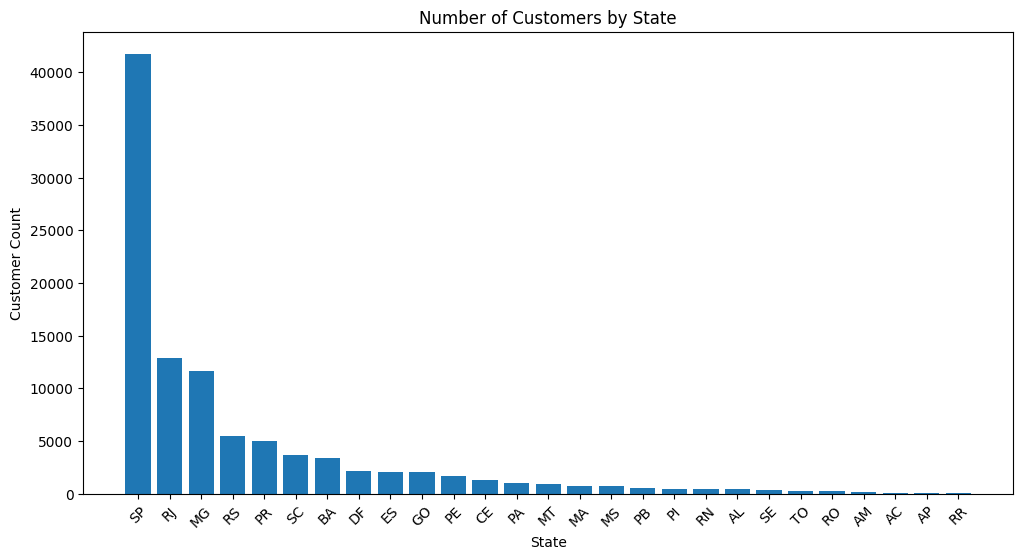

In [21]:
# Customers per state
cur.execute("""
    SELECT customer_state, COUNT(customer_id) as customer_count
    FROM customers
    GROUP BY customer_state
    ORDER BY customer_count DESC
""")
df_state = pd.DataFrame(cur.fetchall(), columns=["state", "customer_count"])

plt.figure(figsize=(12,6))
plt.bar(df_state["state"], df_state["customer_count"])
plt.title("Number of Customers by State")
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.show()


In [22]:
# Revenue percentage by product category (English names)
cur.execute("""
    SELECT
        product_category_name_english as category,
        ROUND((SUM(payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) as sales_percentage
    FROM products_en p
    JOIN order_items oi ON p.product_id = oi.product_id
    JOIN payments pay ON pay.order_id = oi.order_id
    GROUP BY category
    ORDER BY sales_percentage DESC
    LIMIT 10
""")
df_category = pd.DataFrame(cur.fetchall(), columns=["Category", "Percentage"])
print("\nTop 10 Product Categories by Revenue Share:")
print(df_category)



Top 10 Product Categories by Revenue Share:
                Category  Percentage
0         bed_bath_table       10.70
1          health_beauty       10.35
2  computers_accessories        9.90
3          watches_gifts        8.93
4        furniture_decor        8.93
5         sports_leisure        8.70
6             housewares        6.84
7                   auto        5.32
8           garden_tools        5.24
9             cool_stuff        4.87


/tmp/ipython-input-24-4216874546.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month_name', y='order_count', data=df_month, palette='viridis')


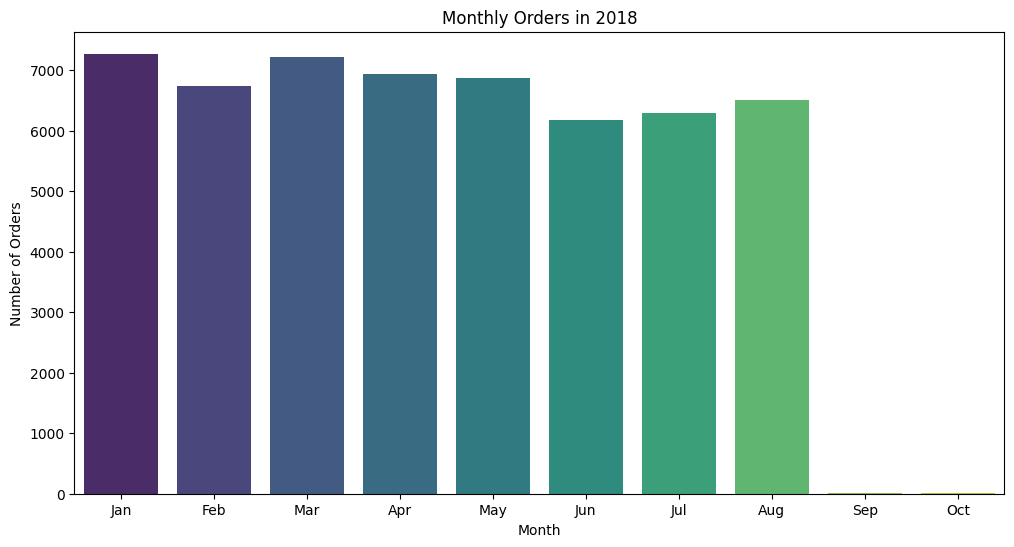

In [24]:
# Orders per month in 2018
cur.execute("""
    SELECT
        strftime('%m', order_purchase_timestamp) as month_num,
        COUNT(order_id) as order_count
    FROM orders
    WHERE strftime('%Y', order_purchase_timestamp) = '2018'
    GROUP BY month_num
    ORDER BY month_num
""")
df_month = pd.DataFrame(cur.fetchall(), columns=["month", "order_count"])

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct']
df_month['month_name'] = month_names

plt.figure(figsize=(12,6))
sns.barplot(x='month_name', y='order_count', data=df_month, palette='viridis')
plt.title("Monthly Orders in 2018")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()


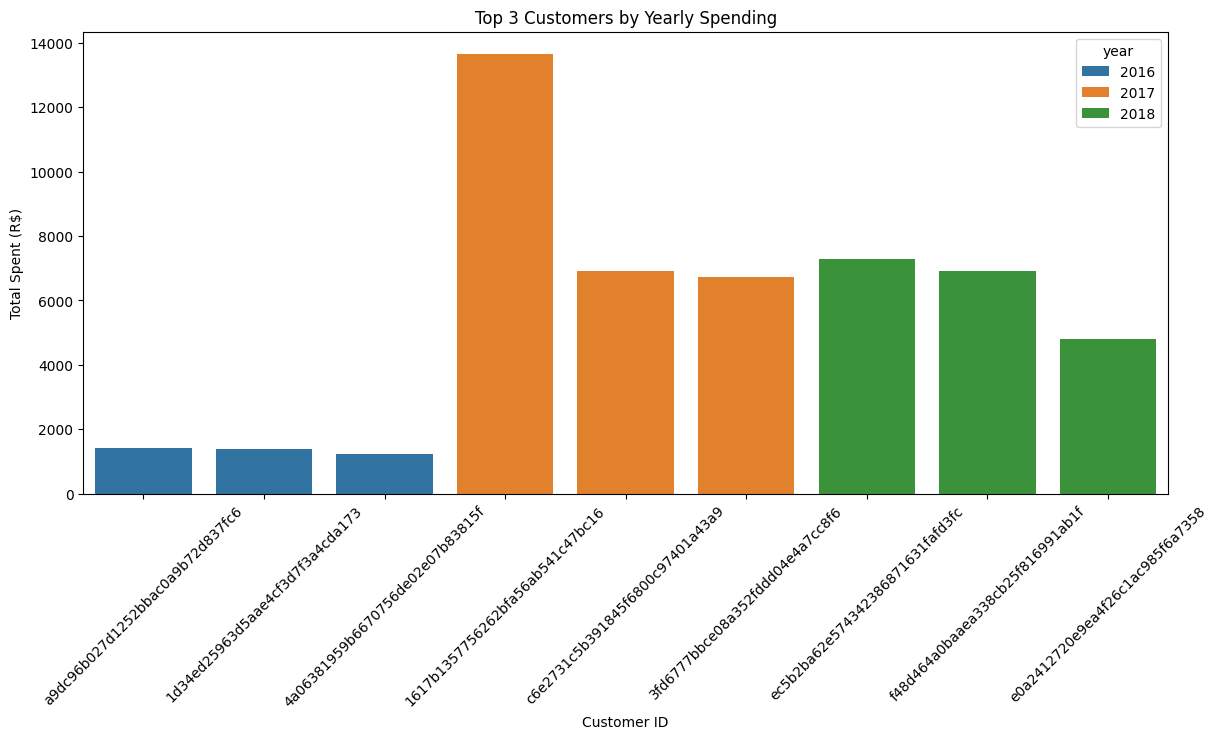

In [25]:
# Top 3 customers by yearly spending
cur.execute("""
    SELECT years, customer_id, payment, d_rank
    FROM (
        SELECT
            strftime('%Y', o.order_purchase_timestamp) years,
            o.customer_id,
            SUM(pay.payment_value) payment,
            DENSE_RANK() OVER (
                PARTITION BY strftime('%Y', o.order_purchase_timestamp)
                ORDER BY SUM(pay.payment_value) DESC
            ) d_rank
        FROM orders o
        JOIN payments pay ON pay.order_id = o.order_id
        GROUP BY years, o.customer_id
    )
    WHERE d_rank <= 3
""")
df_top = pd.DataFrame(cur.fetchall(), columns=["year","customer_id","total_spent","rank"])

plt.figure(figsize=(14,6))
sns.barplot(x='customer_id', y='total_spent', hue='year', data=df_top)
plt.title("Top 3 Customers by Yearly Spending")
plt.xlabel("Customer ID")
plt.ylabel("Total Spent (R$)")
plt.xticks(rotation=45)
plt.show()


In [26]:
# Year-over-Year growth rate
cur.execute("""
    WITH yearly_sales AS (
        SELECT
            strftime('%Y', o.order_purchase_timestamp) AS year,
            SUM(pay.payment_value) AS total_sales
        FROM orders o
        JOIN payments pay ON o.order_id = pay.order_id
        GROUP BY year
        ORDER BY year
    )
    SELECT
        year,
        total_sales,
        ((total_sales - LAG(total_sales) OVER (ORDER BY year)) /
        LAG(total_sales) OVER (ORDER BY year)) * 100 AS yoy_growth
    FROM yearly_sales
""")
df_growth = pd.DataFrame(cur.fetchall(), columns=["year","total_sales","yoy_growth"])
print("\nYear-over-Year Growth:")
print(df_growth)


Year-over-Year Growth:
   year  total_sales    yoy_growth
0  2016     59362.34           NaN
1  2017   7249746.73  12112.703761
2  2018   8699763.05     20.000924


In [27]:
# Close connection
conn.close()


# E-commerce Data Analysis

## Project Objective
This project performs an exploratory data analysis on a public Brazilian e-commerce dataset to understand key business metrics and trends.

## Data Source
The dataset used in this project is the Olist Store Dataset, which is publicly available on Kaggle. It contains information about orders, customers, products, sellers, and reviews from orders made on Olist, the largest department store in Brazilian marketplaces.

## Tools and Libraries Used
*   **Python**: Programming language
*   **pandas**: Data manipulation and analysis
*   **matplotlib** and **seaborn**: Data visualization
*   **sqlite3**: For creating and querying an in-memory SQL database
*   **SQL**: For data extraction and aggregation
*   **Google Colab**: Development environment

## Analysis Performed
The notebook includes the following analyses:
*   Loading and inspecting the datasets.
*   Creating an in-memory SQLite database to perform SQL queries on the data.
*   Analyzing the geographical distribution of customers by state.
*   Identifying the top 10 product categories by revenue share.
*   Analyzing the monthly order volume in 2018.
*   Identifying the top 3 customers by yearly spending.
*   Calculating the year-over-year growth rate in total sales.

## How to Run the Notebook
1.  Clone the repository or download the notebook file (`.ipynb`).
2.  Upload the notebook to Google Colab.
3.  Ensure the dataset CSV files are available in the Colab environment (e.g., by uploading them or mounting Google Drive).
4.  Run the cells sequentially to execute the analysis.